In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random as rd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
import graphviz 
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from scipy.stats import f_oneway
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [4]:
file_path = "C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/cleaned_data.csv"

property_df = pd.read_csv(file_path)
print(property_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  property_type           5147 non-null   object 
 14  propsubtype             5147 non-null   

In [5]:
property_df["saleAmt"].isna().sum()

0

### Analysis on Numerical Columns

In [6]:
num_cols = property_df.columns[property_df.dtypes != 'object']
num_cols

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'saleAmt'], dtype='object')

<AxesSubplot:>

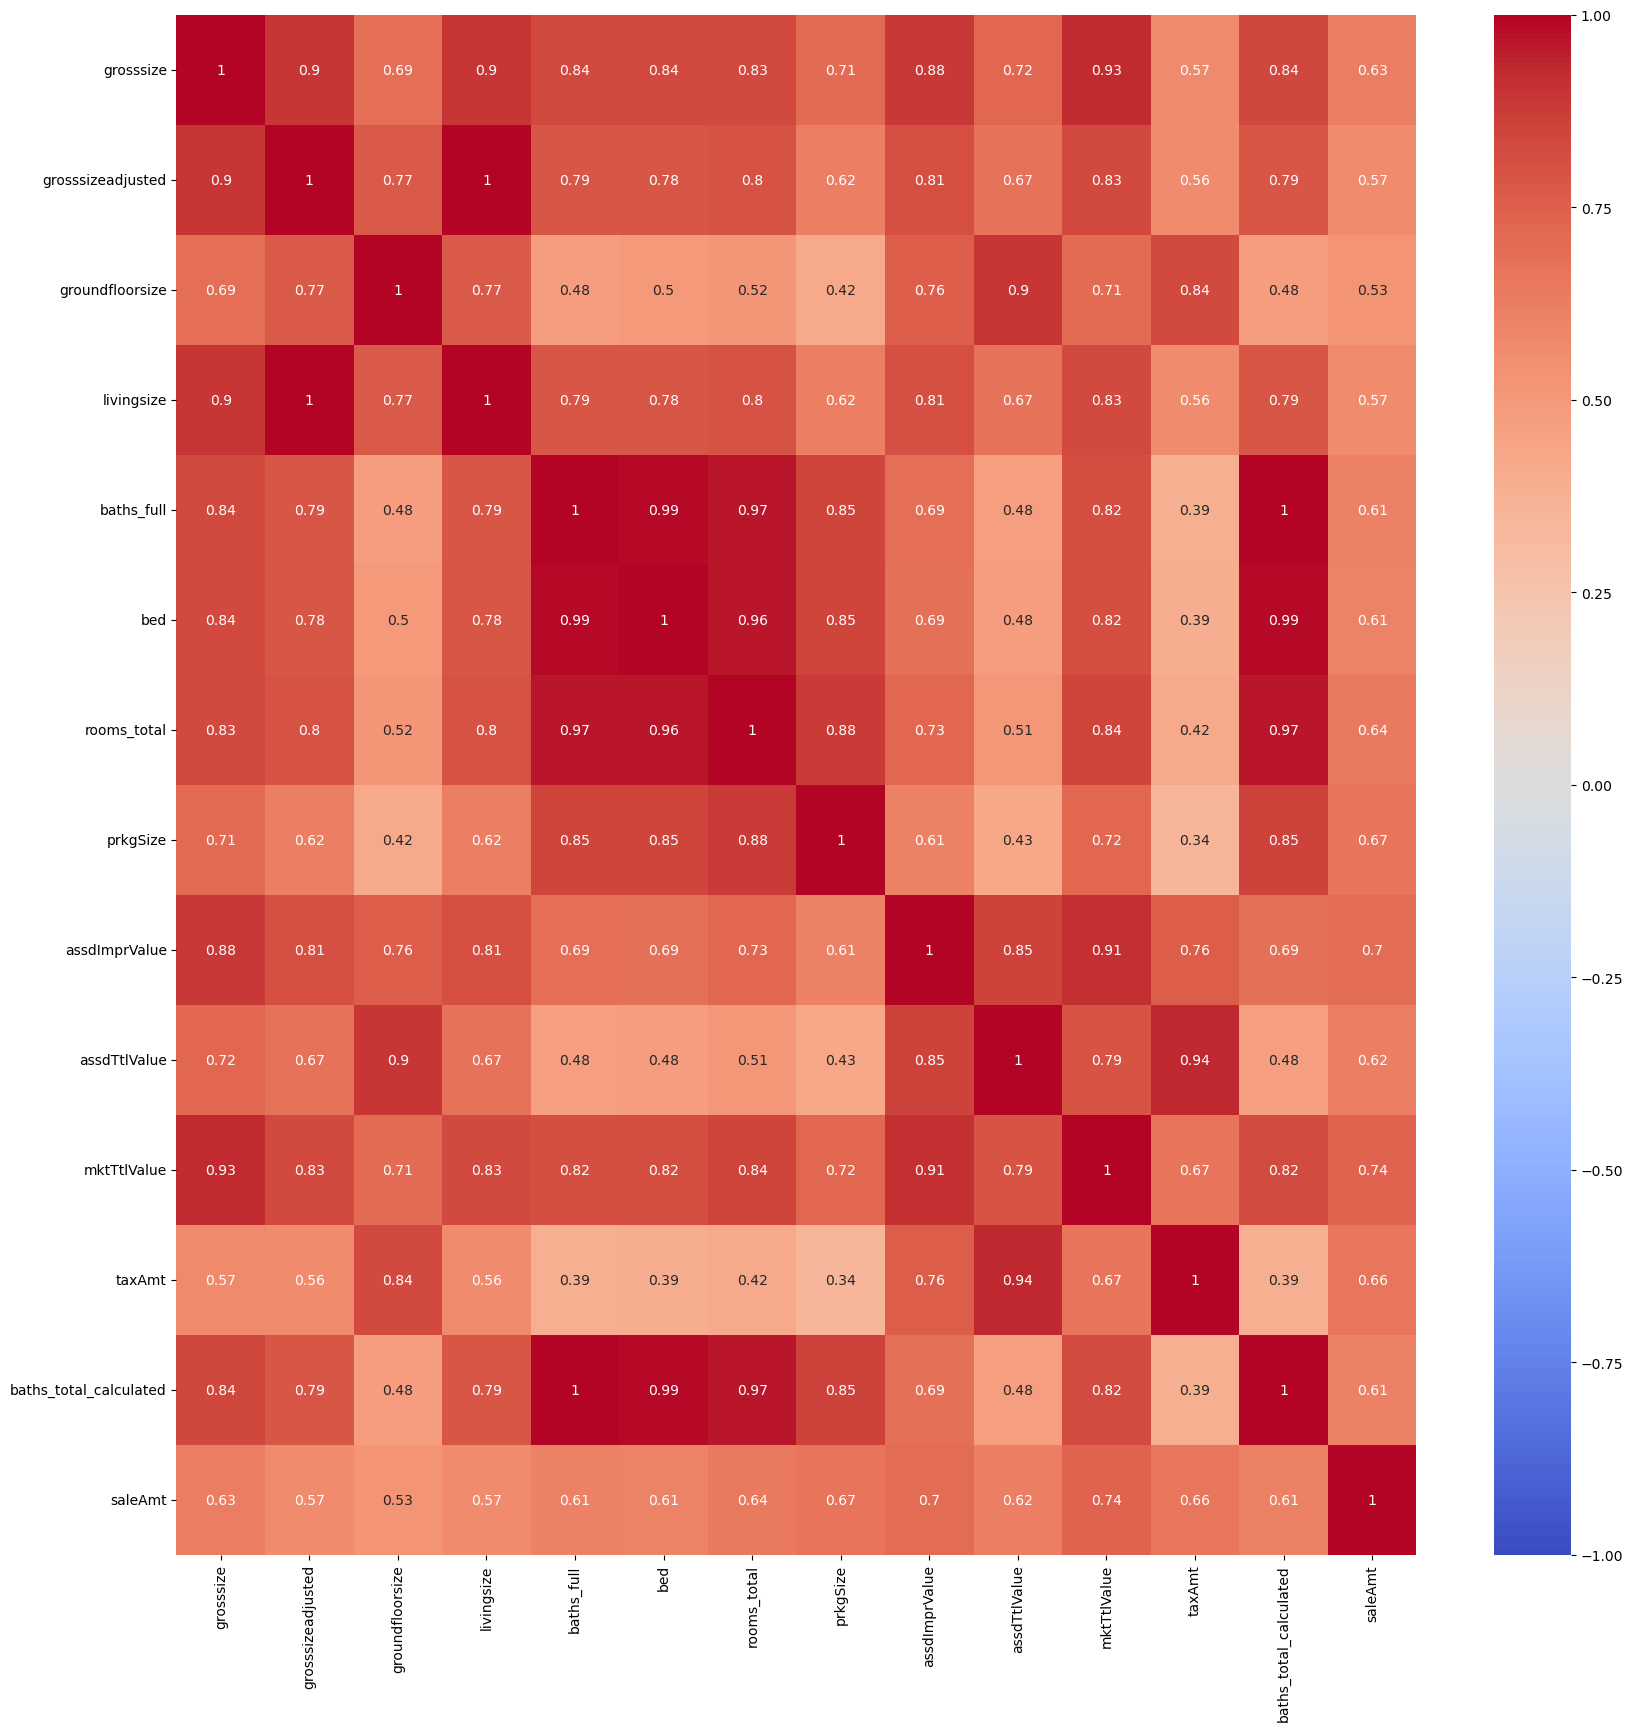

In [7]:
num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df[num_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

### Analysis on Categorical Columns

In [8]:
property_df.describe(include='O')

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
unique,30,7,29,10,6,12,2930,5,11,5,6,4
top,SINGLE FAMILY RESIDENCE,RESIDENTIAL,SFR,FORCED AIR,CENTRAL,BRICK VENEER,2005-03-04,AVERAGE,FRAME,WOOD,"Garage, Attached",CONVENTIONAL HOUSE
freq,2479,4978,2556,4239,2835,2421,33,2674,3195,3267,3361,2981


#### Convert Required Categorical Columns to Numerical Columns for Clustering

In [9]:
data = property_df

# Define a significance level (alpha) for the ANOVA test
alpha = 0.05

# Initialize a list to store columns with significant dependency
significant_cols = []

# Iterate through categorical columns
categorical_columns = data.columns[property_df.dtypes == 'object']
# categorical_columns = ['property_type', 'absenteeInd', 'heatingtype', 'coolingtype', 'wallType', 'saleTransType', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType']

for column in categorical_columns:
    # Perform ANOVA test for independence
    groups = [data[data[column] == category]['saleAmt'] for category in data[column].unique()]
    f_statistic, p_value = f_oneway(*groups)
    
    # Check if the p-value is less than alpha (indicating significant dependency)
    if p_value < alpha:
        significant_cols.append(column)

# Select only the significant columns from the dataset
data_filtered = data[significant_cols + ['saleAmt']]

# Perform target encoding for the selected columns
encoder = ce.TargetEncoder()
data_encoded = encoder.fit_transform(data_filtered.drop('saleAmt', axis=1), data_filtered['saleAmt'])

# Combine the encoded data with the original 'saleAmt' column
property_df_encoded = pd.concat([data_encoded, data_filtered['saleAmt']], axis=1)

property_df_encoded.head(5)

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmt
0,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,713242.190135,6.061591e+05,685772.730203,741104.830425,603424.419521,2.399808e+06,501930.0
1,393683.553323,691279.568903,393683.553323,677479.963671,701893.005226,828838.765778,676663.905204,6.061591e+05,685772.730203,741104.830425,786176.916989,6.092664e+05,179350.0
2,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,792087.341937,7.907225e+05,685772.730203,741104.830425,786176.916989,7.643636e+05,1900000.0
3,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,832184.472070,6.061591e+05,744620.611224,744620.611224,786176.916989,7.643636e+05,1100000.0
4,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,751763.406140,1.201011e+06,744620.611224,744620.611224,786176.916989,7.643636e+05,798000.0


In [10]:
# Drop categorical columns in property_df
property_df = property_df.select_dtypes(exclude=['object'])

# Merge the encoded categorical columns data to property_df
property_df = pd.concat([property_df, property_df_encoded.drop('saleAmt', axis=1)], axis=1)
property_df.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5.147000e+03
mean,2909.412862,1982.077132,1647.700818,1982.077132,2.071304,3.543423,7.492326,495.264846,4.645036e+04,7.128977e+04,8.490291e+05,6541.914312,2.944822,7.448479e+05,6.912288e+05,7.392740e+05,6.912433e+05,7.417029e+05,7.399729e+05,7.379896e+05,7.480519e+05,7.448770e+05,7.309487e+05,7.403743e+05,744761.478359,7.450742e+05
std,8699.439421,5067.840521,4284.518558,5067.840521,13.268863,13.558907,24.028648,1172.644111,1.561694e+05,2.439678e+05,2.115490e+06,21363.092294,13.268904,2.353568e+06,7.706794e+05,2.981515e+05,7.701445e+05,3.000136e+05,2.531116e+05,1.853134e+05,2.866732e+05,2.363256e+05,2.549569e+05,7.295949e+04,118516.285610,2.788011e+05
min,90.000000,90.000000,8.000000,90.000000,0.000000,1.000000,1.000000,86.000000,2.900000e+02,3.430000e+02,1.300000e+03,33.840000,0.000000,5.000000e+02,3.936836e+05,6.912796e+05,3.936836e+05,5.515735e+05,7.018930e+05,5.245341e+05,5.162916e+05,6.061591e+05,6.097213e+05,6.275322e+05,392588.149215,6.092664e+05
25%,1027.500000,970.000000,857.000000,970.000000,1.000000,2.000000,5.000000,260.000000,1.972400e+04,2.889500e+04,4.086000e+05,2713.380000,2.000000,3.290000e+05,3.936836e+05,6.912796e+05,3.936836e+05,6.774800e+05,7.018930e+05,5.245341e+05,6.920765e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,6.092664e+05
50%,1938.000000,1312.000000,1121.000000,1312.000000,1.000000,3.000000,6.000000,480.000000,2.725100e+04,4.545300e+04,6.459000e+05,4257.880000,2.000000,4.980000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.288388e+05,7.159185e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,7.643636e+05
75%,3214.500000,2006.500000,1592.000000,2006.500000,2.000000,4.000000,8.000000,506.000000,3.926400e+04,6.301250e+04,8.931500e+05,5956.320000,3.000000,7.600000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.504536e+05,7.502952e+05,7.907225e+05,7.446206e+05,7.446206e+05,786176.916989,7.643636e+05
max,362967.000000,165530.000000,172081.000000,165530.000000,518.000000,518.000000,966.000000,50626.000000,5.077697e+06,1.120128e+07,7.809005e+07,982413.360000,518.000000,1.042500e+08,9.974938e+06,3.182450e+06,9.974938e+06,2.836450e+06,2.599094e+06,2.113130e+06,1.421175e+07,1.968083e+06,3.231621e+06,1.590885e+06,869456.297873,2.399808e+06


In [11]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

### Normalize Data

In [12]:
scaler = MinMaxScaler()

property_df_normalized = scaler.fit_transform(property_df)
property_df_normalized = pd.DataFrame(property_df_normalized, columns=property_df.columns)

property_df_normalized.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,0.007770,0.011437,0.009529,0.011437,0.003999,0.004920,0.006728,0.008098,0.009091,0.006334,0.010856,0.006625,0.005685,0.007140,0.031055,0.019266,0.031056,0.083212,0.020072,0.134367,0.016922,0.101854,0.046236,0.117135,0.738513,0.075847
std,0.023974,0.030632,0.024899,0.030632,0.025616,0.026226,0.024900,0.023202,0.030758,0.021781,0.027091,0.021746,0.025616,0.022576,0.080436,0.119683,0.080380,0.131304,0.133413,0.116652,0.020932,0.173523,0.097241,0.075735,0.248531,0.155708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002584,0.005319,0.004934,0.005319,0.001931,0.001934,0.004145,0.003443,0.003828,0.002549,0.005216,0.002728,0.003861,0.003151,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012835,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005093,0.007386,0.006468,0.007386,0.001931,0.003868,0.005181,0.007796,0.005310,0.004027,0.008255,0.004300,0.003861,0.004772,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014576,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008610,0.011584,0.009205,0.011584,0.003861,0.005803,0.007254,0.008310,0.007676,0.005595,0.011421,0.006029,0.005792,0.007285,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017086,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662


In [14]:
property_df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

In [15]:
min_sale_amt = property_df_normalized["saleAmt"].min()
max_sale_amt = property_df_normalized["saleAmt"].max()

print("Minimum saleAmt:", min_sale_amt)
print("Maximum saleAmt:", max_sale_amt)

Minimum saleAmt: 0.0
Maximum saleAmt: 0.9999999999999999


In [16]:
property_df_normalized["saleAmt"].isna().sum()

0

In [17]:
property_df_normalized["saleAmt"].describe()

count    5147.000000
mean        0.007140
std         0.022576
min         0.000000
25%         0.003151
50%         0.004772
75%         0.007285
max         1.000000
Name: saleAmt, dtype: float64

In [18]:
bins = [-1, 0.003151, 0.004772, 0.007285, 1]
labels = ['Economical Price', 'Budget-Friendly Price', 'Standard Price', 'Premium Price']

property_df_normalized['saleAmtCategory'] = pd.cut(property_df_normalized['saleAmt'], bins=bins, labels=labels)

In [19]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmtCategory
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000,Standard Price
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000,Economical Price
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662,Premium Price
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662,Premium Price
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662,Premium Price


In [20]:
property_df_normalized["saleAmtCategory"].isna().sum()

0

In [21]:
property_df_normalized.to_csv("C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/property_data_supervised.csv", mode='w', index=False)

### Decision Trees

In [22]:
y = property_df_normalized["saleAmtCategory"]
X = property_df_normalized.drop(['saleAmt', 'saleAmtCategory'], axis = 1)

X.columns

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'property_type', 'propsubtype', 'proptype', 'heatingtype', 'coolingtype', 'wallType', 'saleRecDate', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType'], dtype='object')

In [23]:
y.isna().sum()

0

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
y_train.describe(include='all')

count               4117
unique                 4
top       Standard Price
freq                1062
Name: saleAmtCategory, dtype: object

In [26]:
X_train.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000
mean,0.008051,0.011737,0.009713,0.011737,0.004251,0.005171,0.006998,0.008338,0.009278,0.006480,0.011094,0.006718,0.005942,0.031996,0.019884,0.031982,0.083325,0.019617,0.134591,0.017036,0.101530,0.046849,0.116964,0.738949,0.076559
std,0.026422,0.033339,0.026533,0.033339,0.028510,0.029057,0.027762,0.025823,0.033222,0.023619,0.029822,0.023028,0.028498,0.085020,0.121831,0.084964,0.131817,0.131849,0.116955,0.022670,0.173863,0.099850,0.074678,0.247986,0.157273
min,0.000000,0.000000,0.000918,0.000000,0.000000,0.000000,0.000000,0.000277,0.000046,0.000016,0.000025,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002596,0.005349,0.004928,0.005349,0.001931,0.001934,0.004145,0.003443,0.003847,0.002541,0.005216,0.002729,0.003861,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012842,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005186,0.007435,0.006491,0.007435,0.001931,0.003868,0.005181,0.007796,0.005330,0.004046,0.008274,0.004316,0.003861,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014565,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008697,0.011642,0.009205,0.011642,0.003861,0.005803,0.007254,0.008310,0.007647,0.005621,0.011451,0.006036,0.005792,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017047,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
y_test.describe(include='all')

count                 1030
unique                   4
top       Economical Price
freq                   281
Name: saleAmtCategory, dtype: object

In [28]:
X_test.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.006643,0.010236,0.008795,0.010236,0.002989,0.003914,0.005648,0.007139,0.008345,0.005749,0.009904,0.006252,0.004658,0.027293,0.016797,0.027356,0.082759,0.021887,0.133474,0.016469,0.103150,0.043787,0.117818,0.736769,0.073003
std,0.008950,0.015650,0.016846,0.015650,0.005370,0.007826,0.004036,0.004877,0.017767,0.011857,0.010567,0.015610,0.005616,0.058520,0.110705,0.058472,0.129295,0.139541,0.115487,0.011625,0.172236,0.086030,0.079853,0.250811,0.149327
min,0.000606,0.001330,0.000000,0.001330,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002555,0.005266,0.004946,0.005266,0.001931,0.001934,0.004145,0.003443,0.003724,0.002564,0.005218,0.002718,0.003861,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012785,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.004743,0.007308,0.006413,0.007308,0.001931,0.003868,0.005181,0.007440,0.005255,0.003978,0.008198,0.004245,0.003861,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014611,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008314,0.011421,0.009165,0.011421,0.003861,0.005803,0.007254,0.008271,0.007736,0.005533,0.011358,0.005928,0.005792,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017281,0.135517,0.051451,0.121543,0.825362,0.086620
max,0.132651,0.290957,0.421286,0.290957,0.156371,0.232108,0.077720,0.041828,0.279029,0.217599,0.210244,0.352382,0.156371,1.000000,0.827990,1.000000,1.000000,1.000000,0.646631,0.311998,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
DT1 = DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                             splitter='best',  ## or "random" or "best"
                             max_depth=3, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             random_state=None, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             class_weight=None)

DT1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [30]:
feature_names = X_train.columns

In [31]:
class_names = y_train.unique()

[Text(0.5, 0.875, 'saleRecDate <= 0.014\nentropy = 2.0\nsamples = 4117\nvalue = [1037, 1004, 1014, 1062]\nclass = Premium Price'),
 Text(0.25, 0.625, 'saleRecDate <= 0.013\nentropy = 1.548\nsamples = 1924\nvalue = [743, 881, 37, 263]\nclass = Budget-Friendly Price'),
 Text(0.125, 0.375, 'mktTtlValue <= 0.008\nentropy = 0.932\nsamples = 950\nvalue = [148, 748, 1, 53]\nclass = Budget-Friendly Price'),
 Text(0.0625, 0.125, 'entropy = 0.434\nsamples = 741\nvalue = [52, 683, 0, 6]\nclass = Budget-Friendly Price'),
 Text(0.1875, 0.125, 'entropy = 1.561\nsamples = 209\nvalue = [96, 65, 1, 47]\nclass = Standard Price'),
 Text(0.375, 0.375, 'mktTtlValue <= 0.008\nentropy = 1.48\nsamples = 974\nvalue = [595, 133, 36, 210]\nclass = Standard Price'),
 Text(0.3125, 0.125, 'entropy = 1.284\nsamples = 468\nvalue = [296, 128, 3, 41]\nclass = Standard Price'),
 Text(0.4375, 0.125, 'entropy = 1.3\nsamples = 506\nvalue = [299, 5, 33, 169]\nclass = Standard Price'),
 Text(0.75, 0.625, 'grosssize <= 0.003\

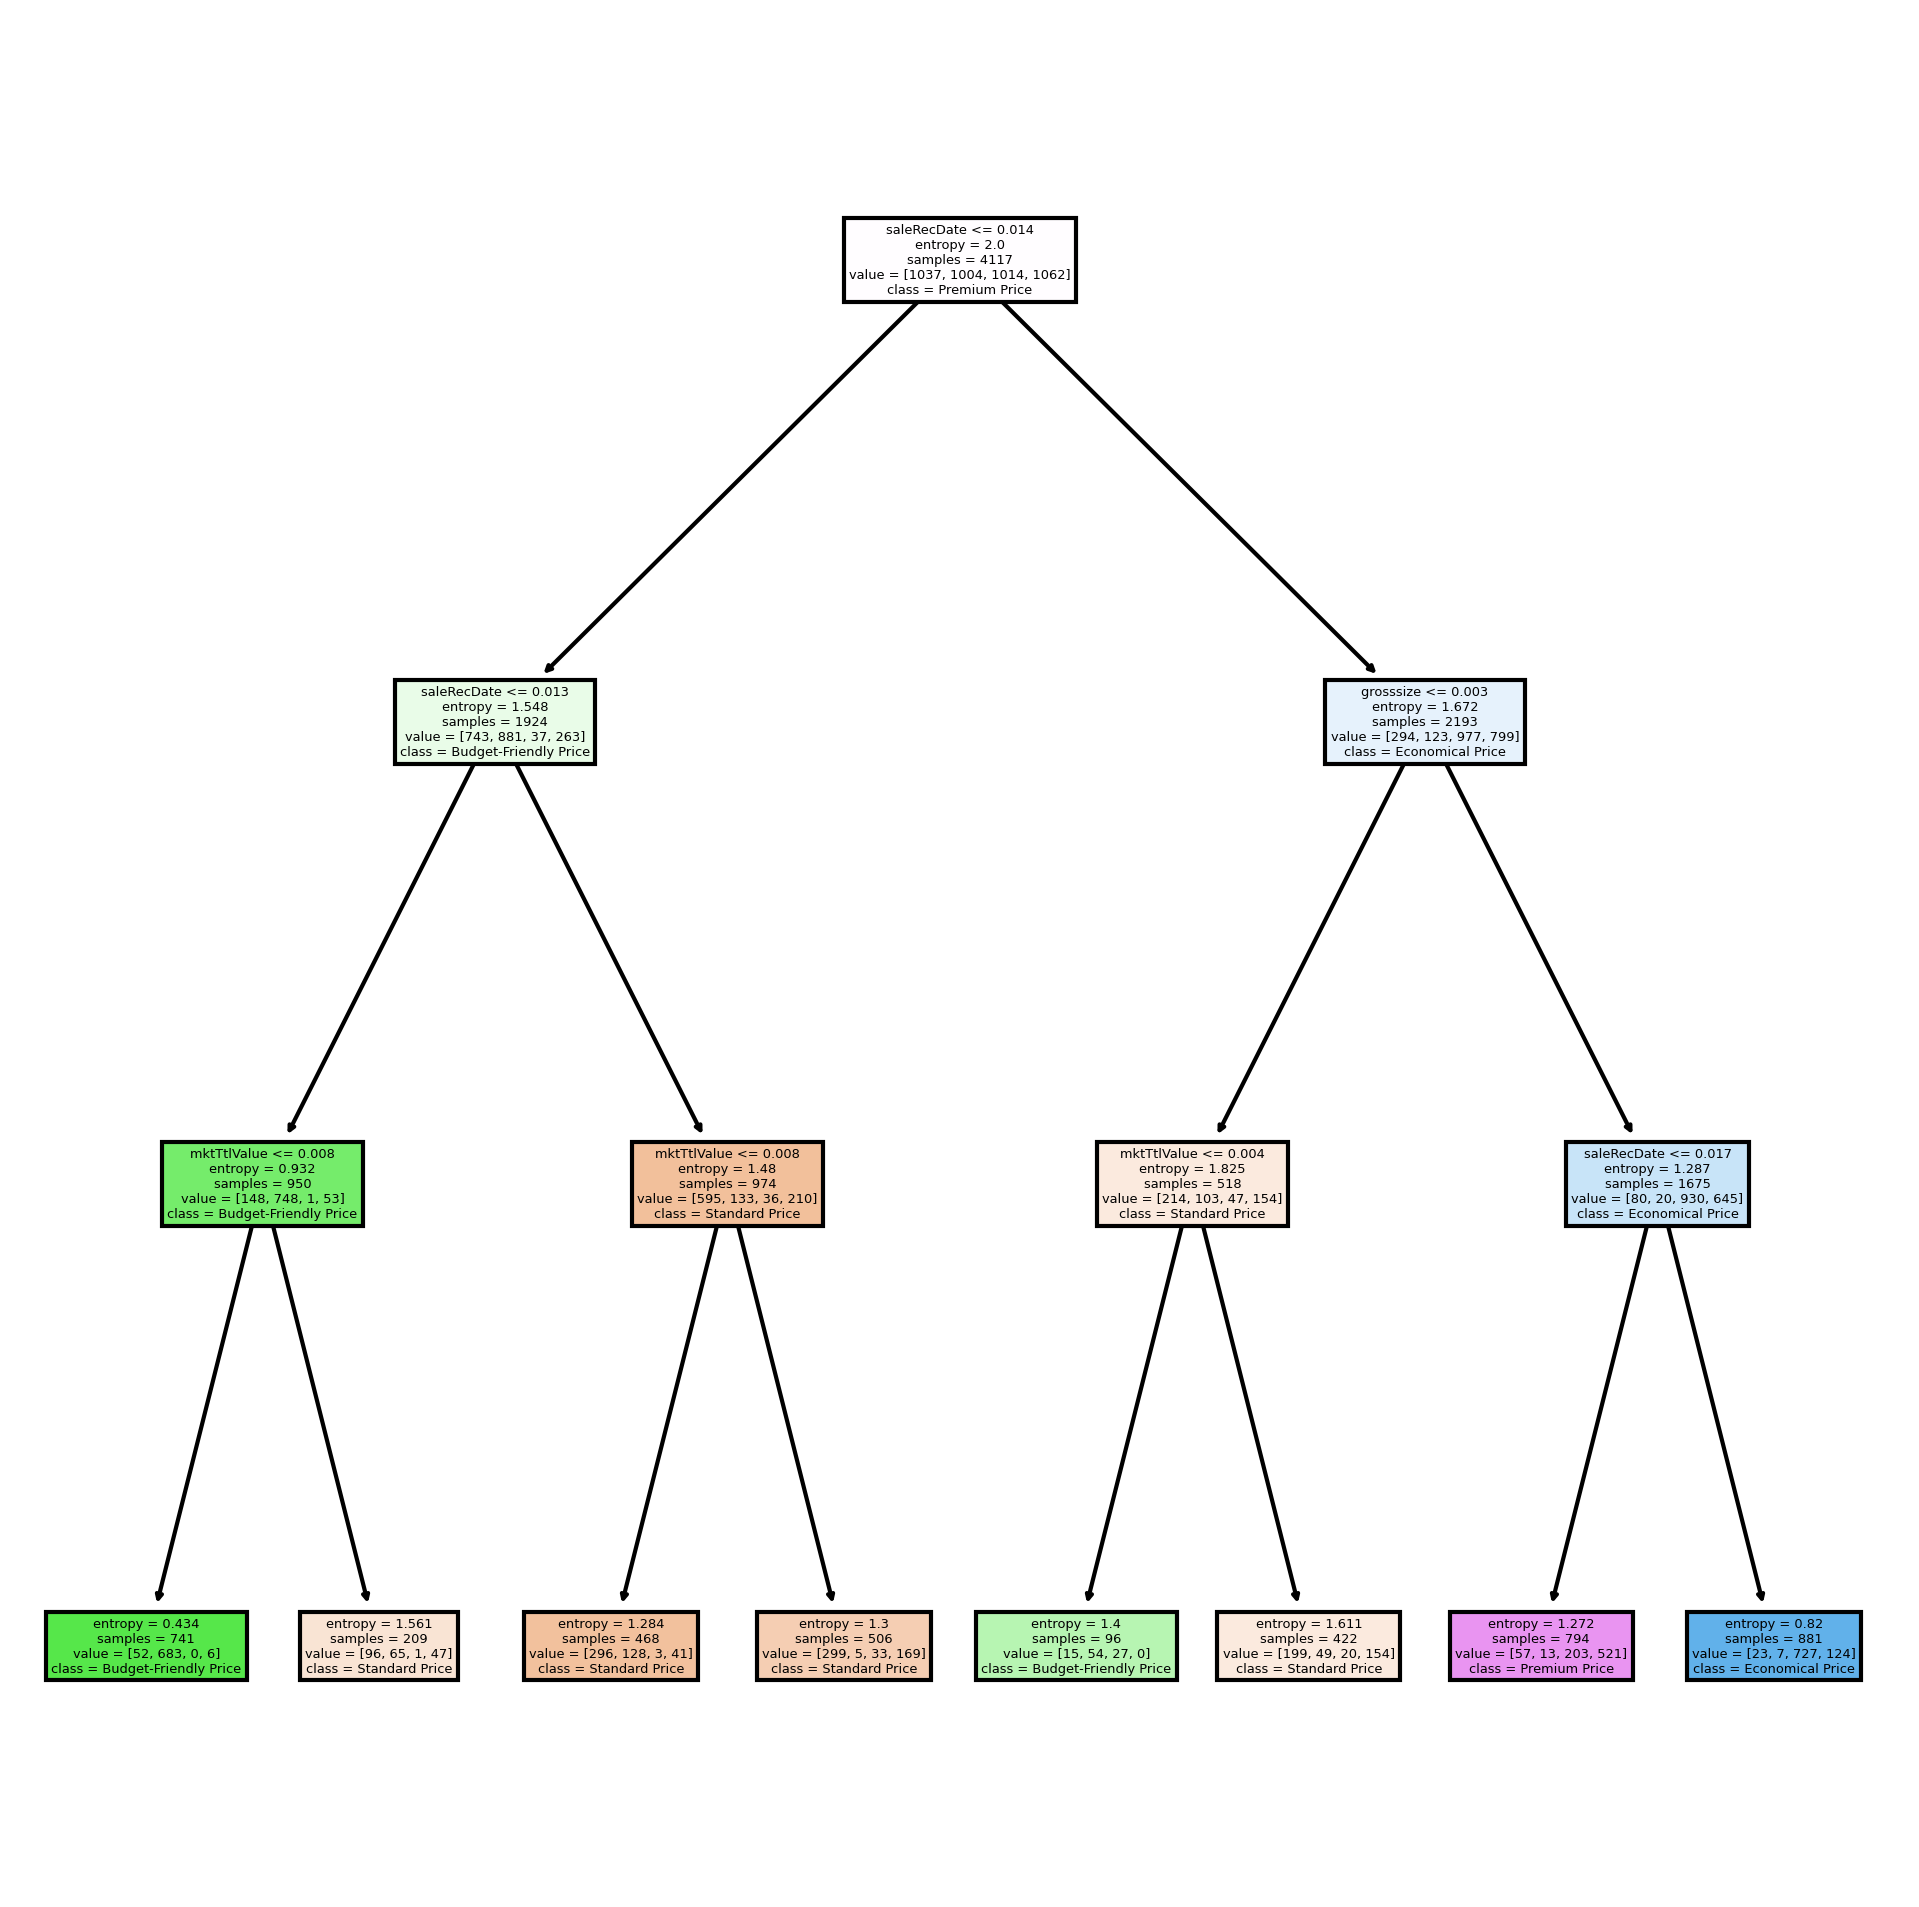

In [32]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 8), dpi=300)
plot_tree(DT1, filled=True, feature_names=feature_names, class_names=class_names, impurity=True, ax=axes)

In [33]:
# Use the classifier to make predictions on the testing data
y_pred = DT1.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[208  25   4  12]
 [ 83 190   3   5]
 [  7  10 199  60]
 [ 85   2  30 107]]


Accuracy of tree with entropy as criterion is: 0.683495145631068


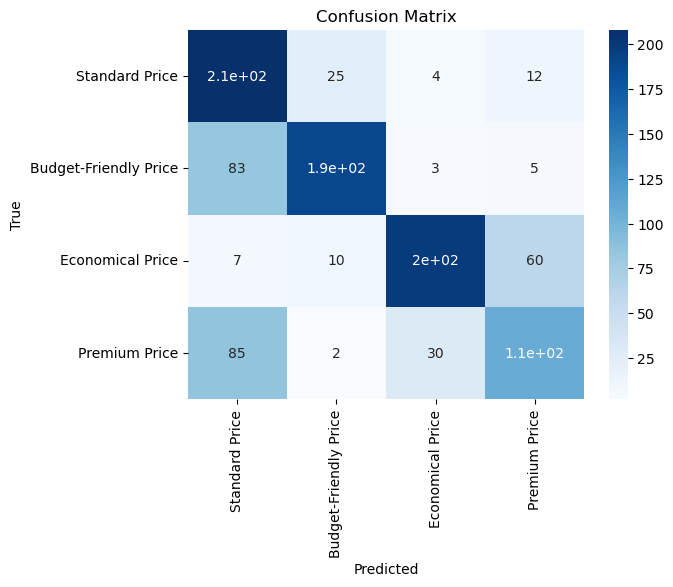

In [55]:
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of tree with entropy as criterion is: " + str(accuracy))

In [36]:
DT2 = DecisionTreeClassifier(criterion='gini', ##"entropy" or "gini"
                             splitter='best',  ## or "random" or "best"
                             max_depth=3, 
                             min_samples_split=2, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             random_state=None, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             class_weight=None)

In [37]:
DT2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

[Text(0.5, 0.875, 'saleRecDate <= 0.013\ngini = 0.75\nsamples = 4117\nvalue = [1037, 1004, 1014, 1062]\nclass = Premium Price'),
 Text(0.25, 0.625, 'mktTtlValue <= 0.008\ngini = 0.356\nsamples = 958\nvalue = [150, 752, 3, 53]\nclass = Budget-Friendly Price'),
 Text(0.125, 0.375, 'saleRecDate <= 0.012\ngini = 0.145\nsamples = 745\nvalue = [52, 687, 0, 6]\nclass = Budget-Friendly Price'),
 Text(0.0625, 0.125, 'gini = 0.059\nsamples = 527\nvalue = [14, 511, 0, 2]\nclass = Budget-Friendly Price'),
 Text(0.1875, 0.125, 'gini = 0.317\nsamples = 218\nvalue = [38, 176, 0, 4]\nclass = Budget-Friendly Price'),
 Text(0.375, 0.375, 'mktTtlValue <= 0.011\ngini = 0.646\nsamples = 213\nvalue = [98, 65, 3, 47]\nclass = Standard Price'),
 Text(0.3125, 0.125, 'gini = 0.569\nsamples = 139\nvalue = [77, 47, 1, 14]\nclass = Standard Price'),
 Text(0.4375, 0.125, 'gini = 0.661\nsamples = 74\nvalue = [21, 18, 2, 33]\nclass = Premium Price'),
 Text(0.75, 0.625, 'saleRecDate <= 0.017\ngini = 0.71\nsamples = 31

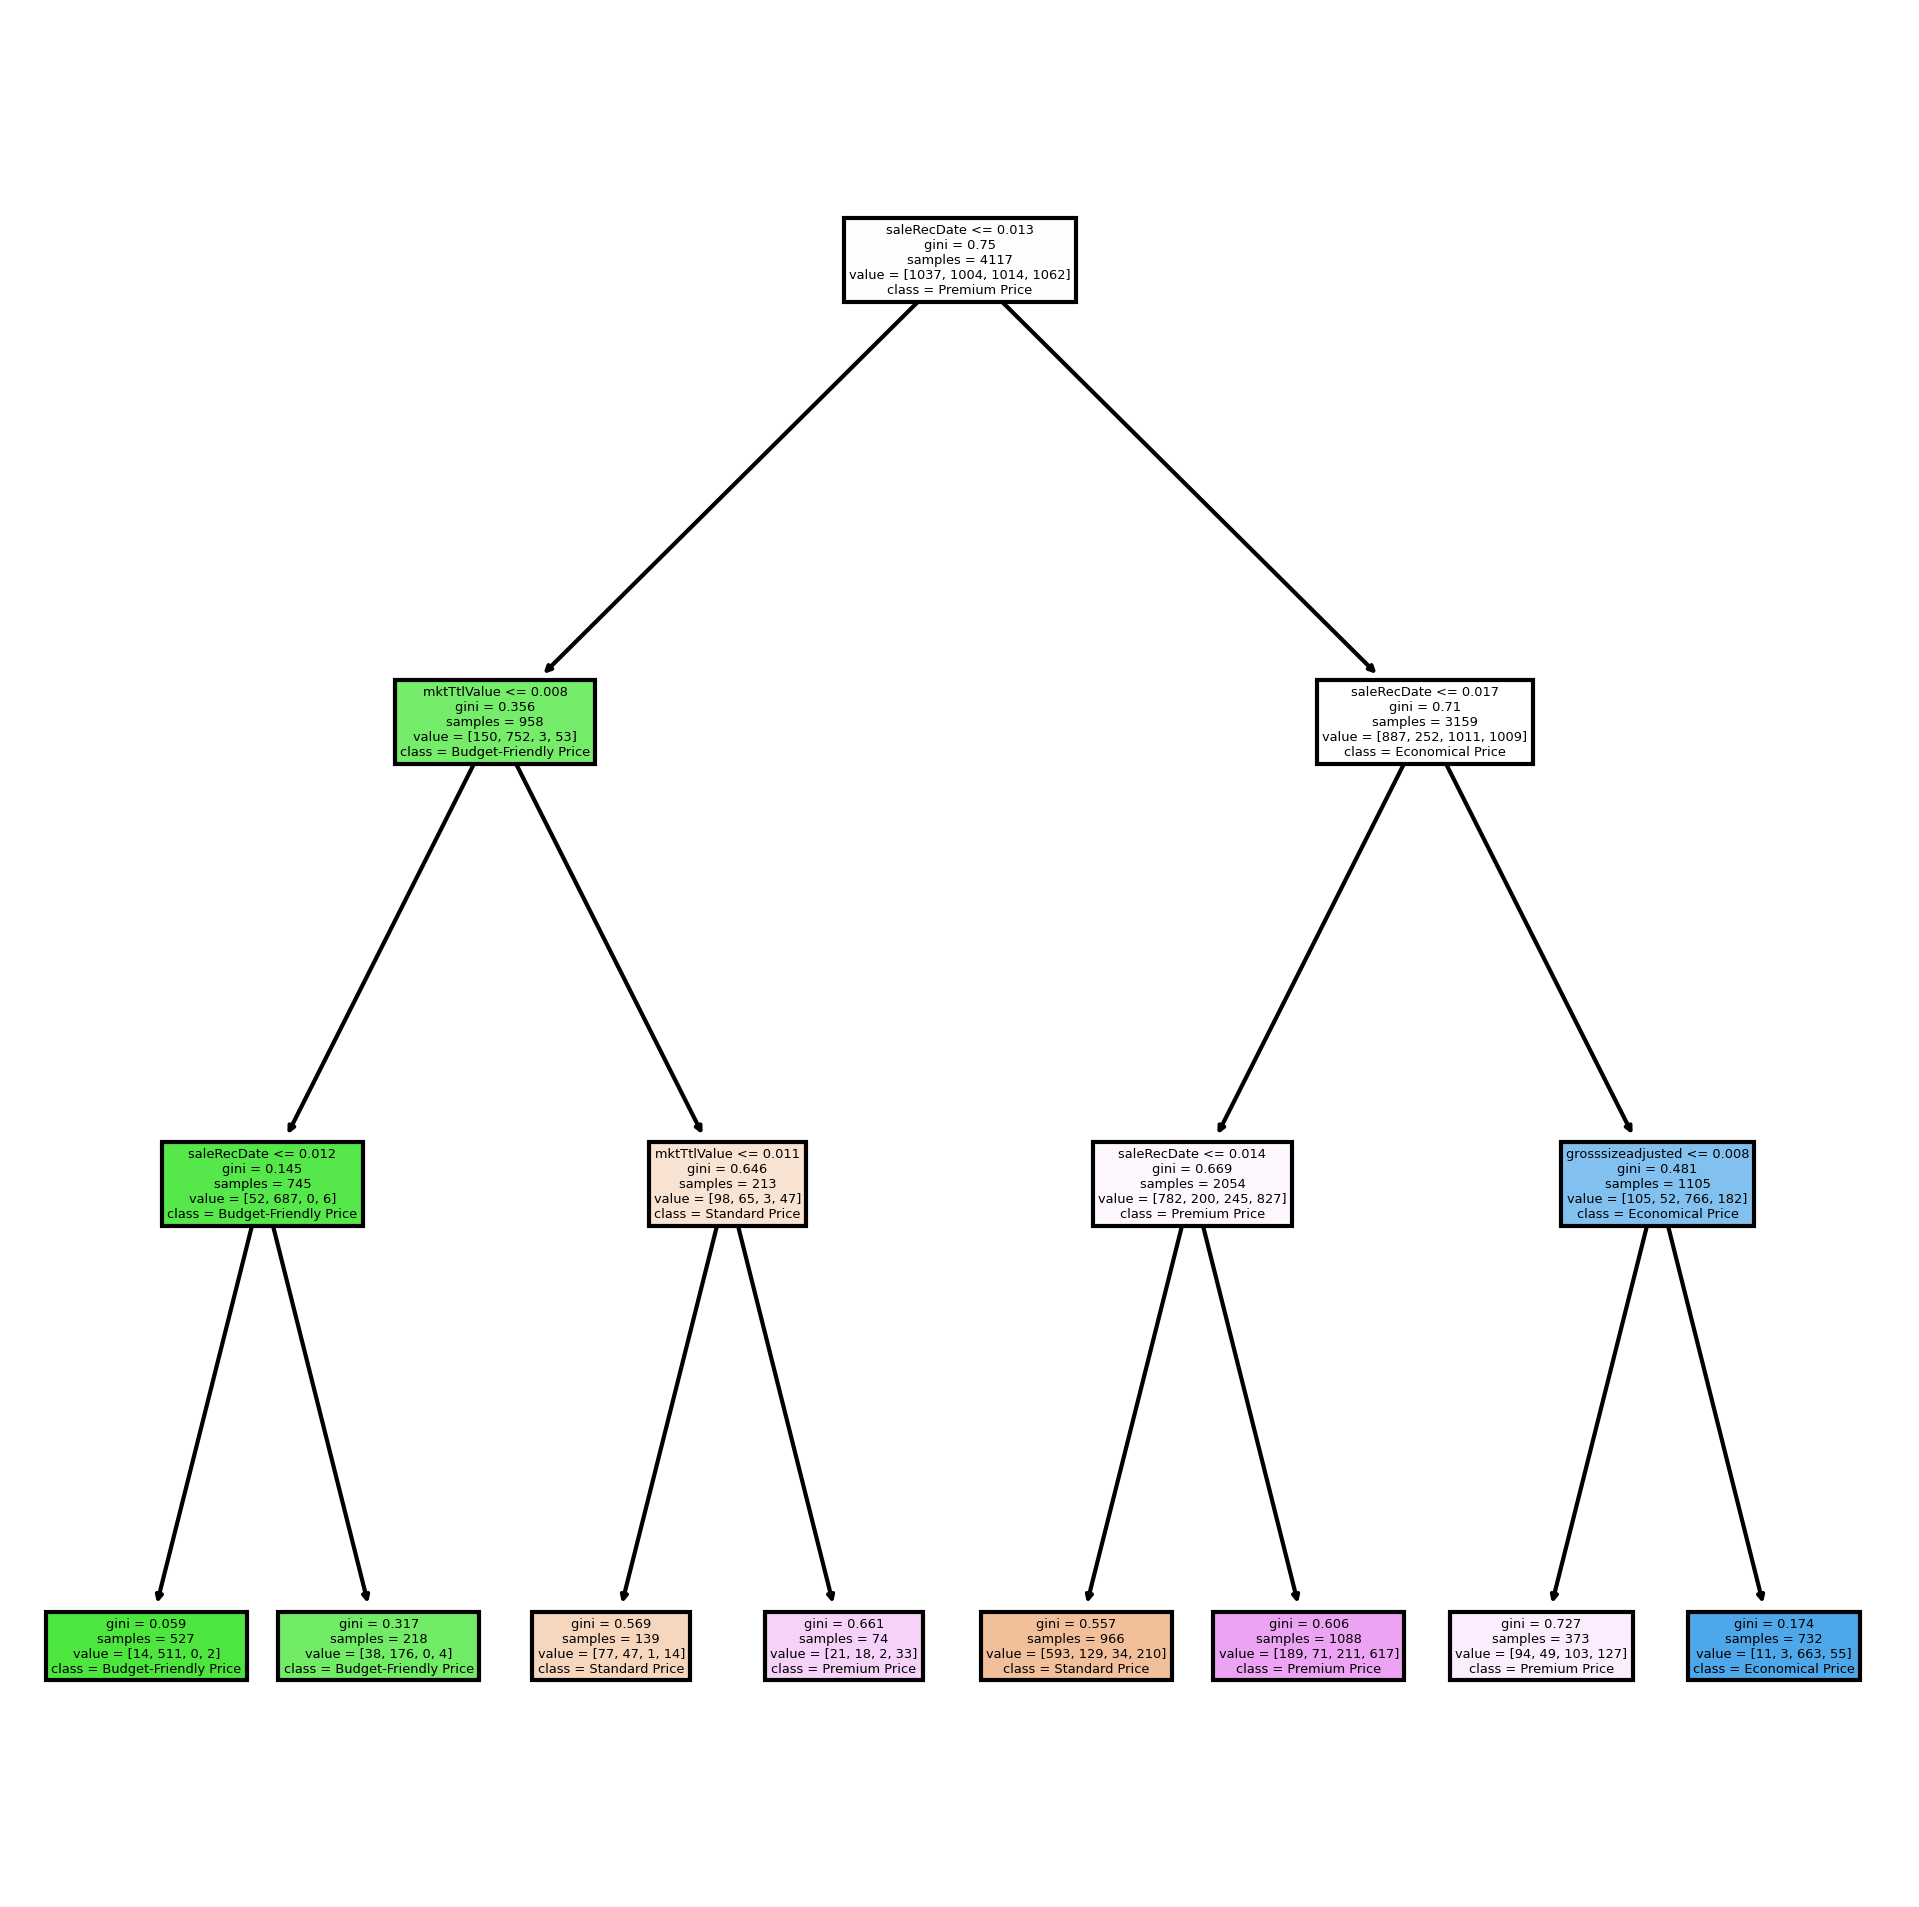

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 8), dpi=300)
plot_tree(DT2, filled=True, feature_names=feature_names, class_names=class_names, impurity=True, ax=axes)

[[162  20   1  66]
 [ 63 176   1  41]
 [  5   0 169 102]
 [ 40   1  18 165]]
Accuracy of tree with gini as criterion is: 0.6524271844660194


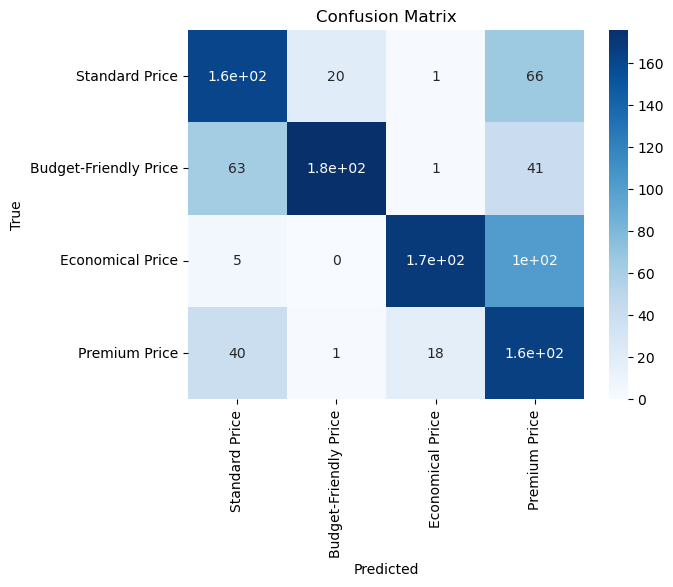

In [39]:
# Use the classifier to make predictions on the testing data
y_pred_2 = DT2.predict(X_test)

# Get the confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2)
print(cm_2)
# Print the confusion matrix

sns.heatmap(cm_2, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Get and Print the accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print("Accuracy of tree with gini as criterion is: " + str(accuracy_2))

In [40]:
DT3 = DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                             splitter='best',  ## or "random" or "best"
                             max_depth=3, 
                             min_samples_split=3, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=4, 
                             random_state=None, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             class_weight=None)

In [41]:
DT3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=4,
                       min_samples_leaf=2, min_samples_split=3)

[Text(0.5, 0.875, 'mktTtlValue <= 0.008\nentropy = 2.0\nsamples = 4117\nvalue = [1037, 1004, 1014, 1062]\nclass = Premium Price'),
 Text(0.25, 0.625, 'grosssize <= 0.002\nentropy = 1.685\nsamples = 1942\nvalue = [588, 937, 110, 307]\nclass = Budget-Friendly Price'),
 Text(0.125, 0.375, 'livingsize <= 0.002\nentropy = 0.824\nsamples = 275\nvalue = [18, 230, 26, 1]\nclass = Budget-Friendly Price'),
 Text(0.0625, 0.125, 'entropy = 0.852\nsamples = 30\nvalue = [0, 5, 24, 1]\nclass = Economical Price'),
 Text(0.1875, 0.125, 'entropy = 0.446\nsamples = 245\nvalue = [18, 225, 2, 0]\nclass = Budget-Friendly Price'),
 Text(0.375, 0.375, 'grosssize <= 0.009\nentropy = 1.72\nsamples = 1667\nvalue = [570, 707, 84, 306]\nclass = Budget-Friendly Price'),
 Text(0.3125, 0.125, 'entropy = 1.626\nsamples = 1600\nvalue = [564, 702, 36, 298]\nclass = Budget-Friendly Price'),
 Text(0.4375, 0.125, 'entropy = 1.302\nsamples = 67\nvalue = [6, 5, 48, 8]\nclass = Economical Price'),
 Text(0.75, 0.625, 'saleRecD

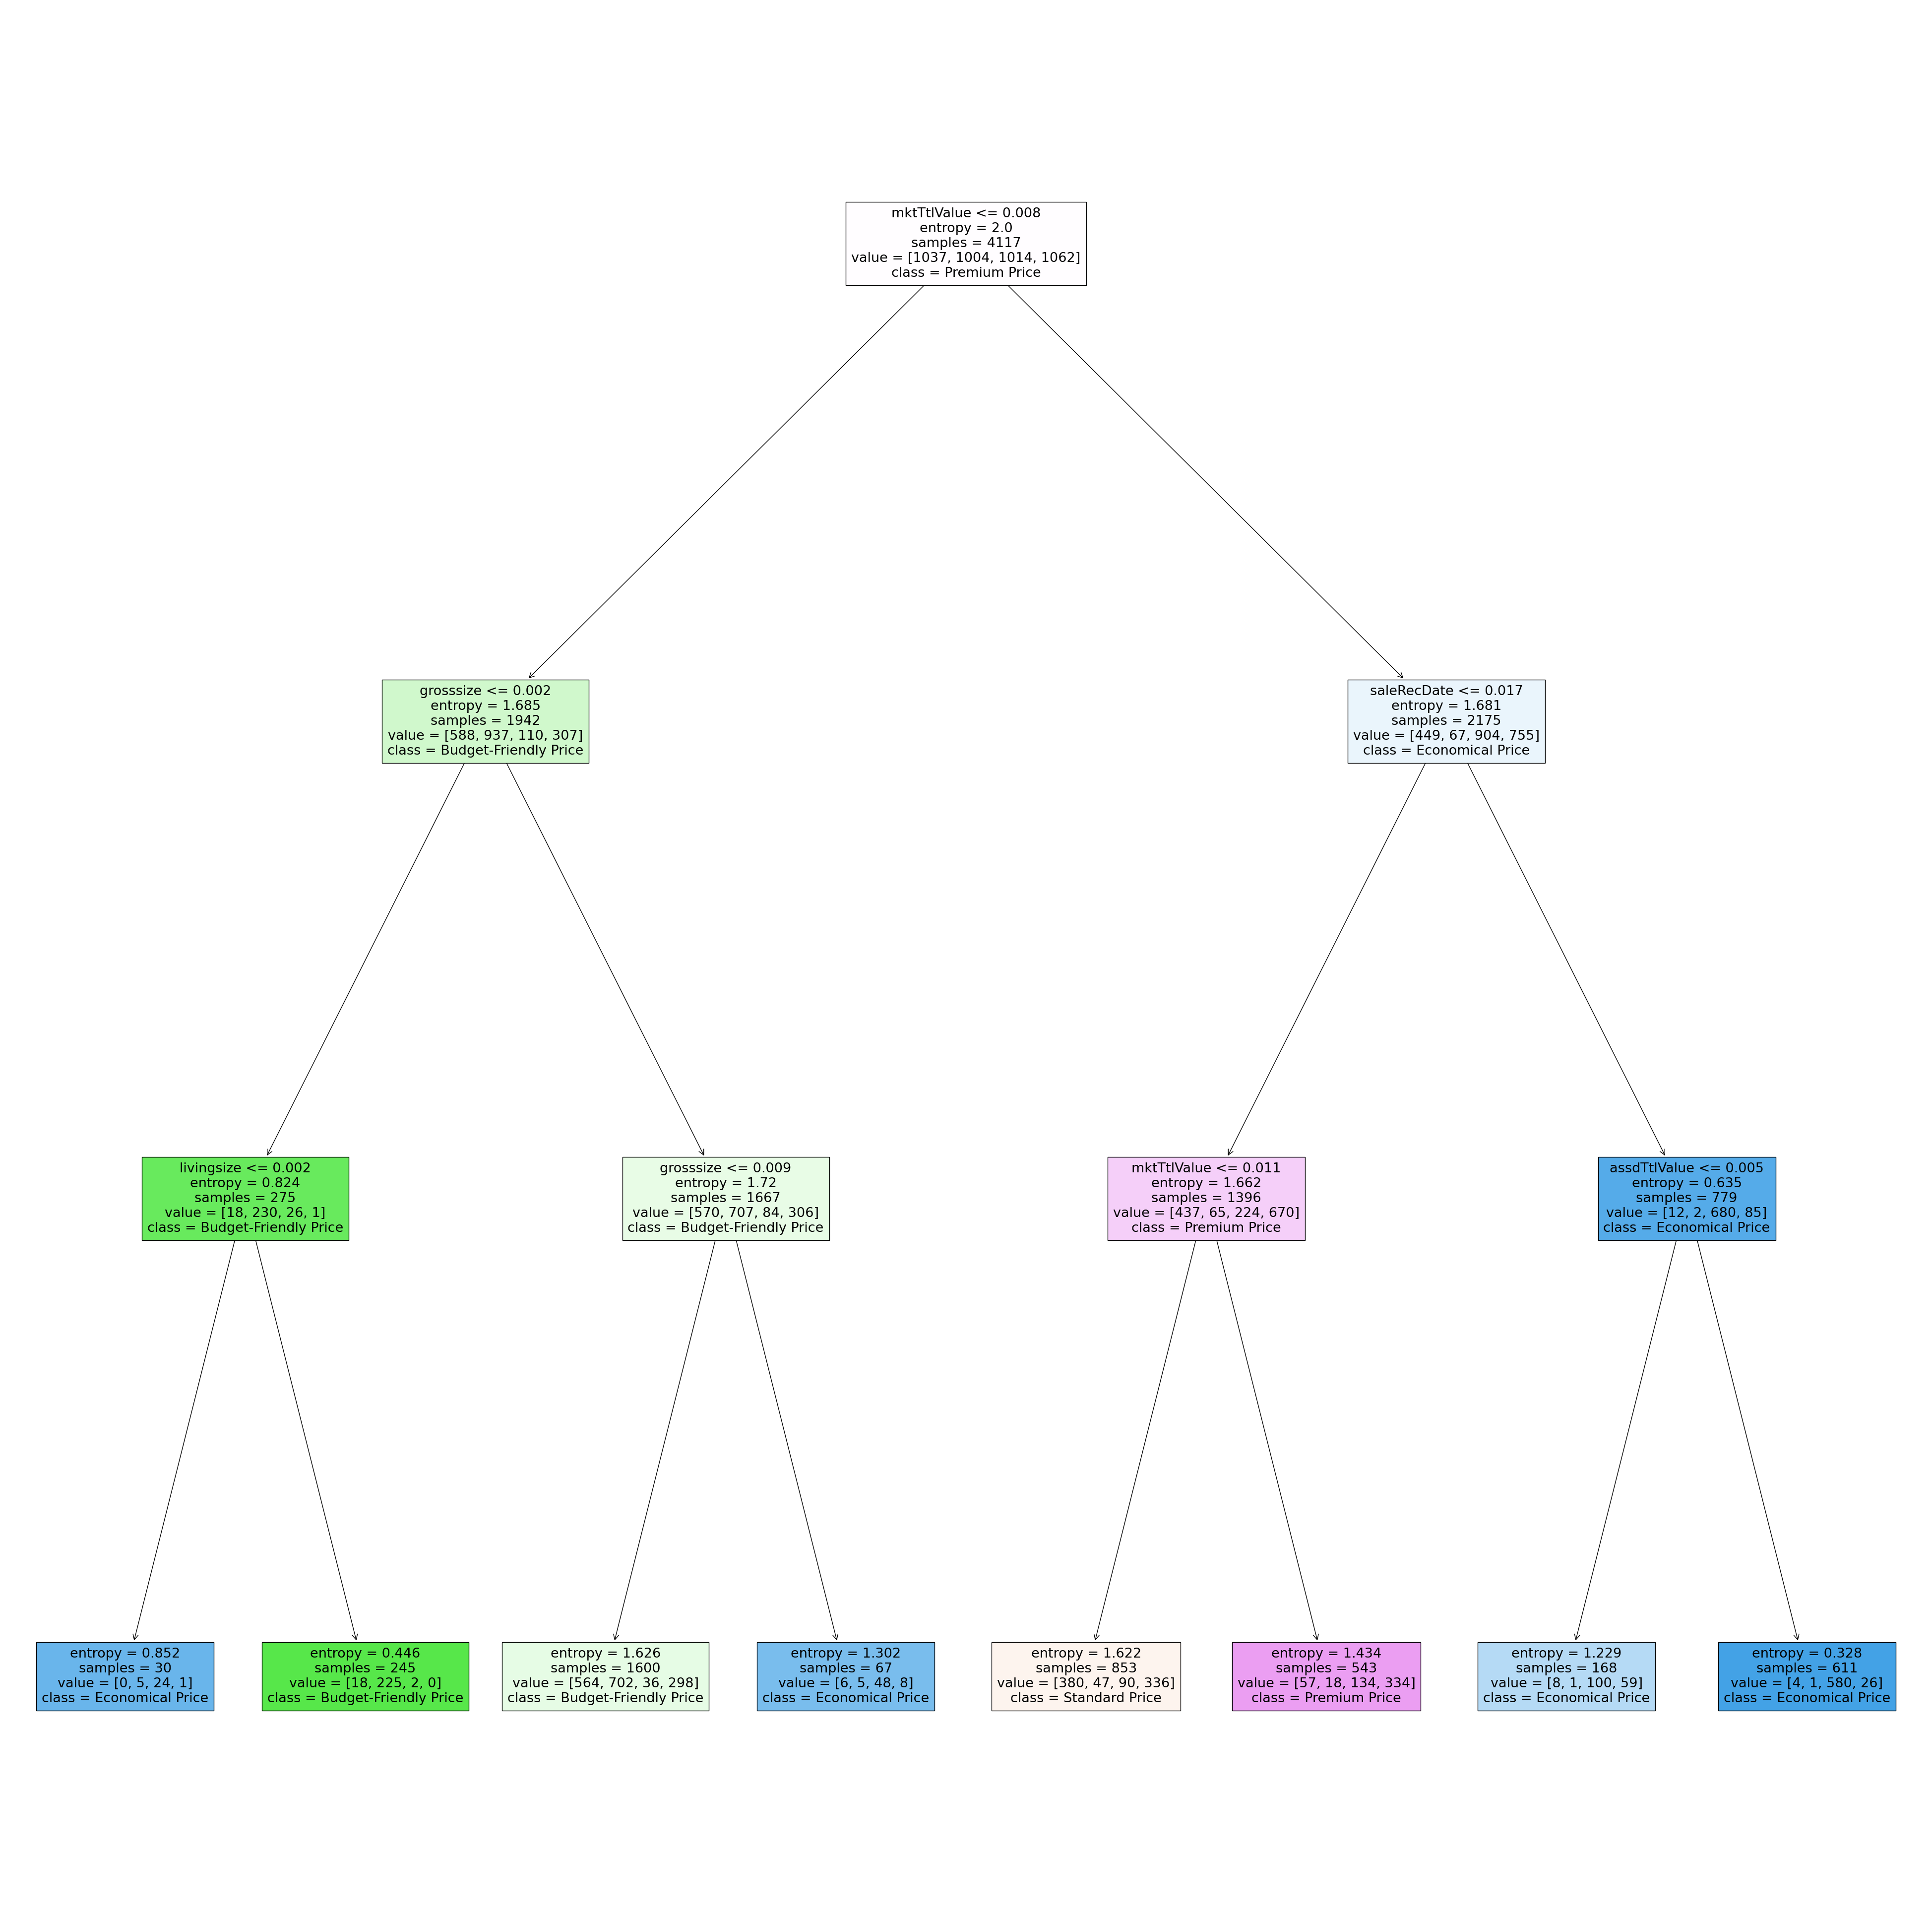

In [42]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (50, 50), dpi=100)
plot_tree(DT3, filled=True, feature_names=feature_names, class_names=class_names, impurity=True, ax=axes)

[[100 131   5  13]
 [ 12 261   3   5]
 [ 22  12 201  41]
 [ 69  71  21  63]]
Accuracy of tree with entropy as criterion, max_depth=4, max_features=4, min_samples_leaf=2, min_samples_split=3 is: 0.6067961165048543


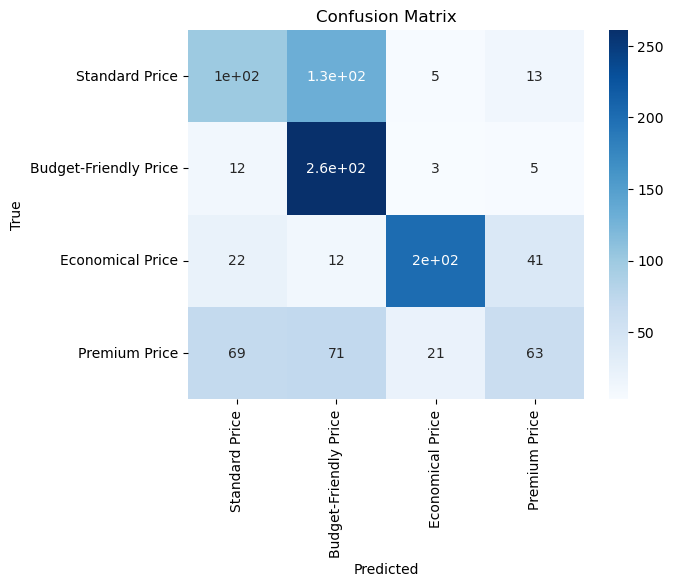

In [43]:
# Use the classifier to make predictions on the testing data
y_pred_3 = DT3.predict(X_test)

# Get the confusion matrix
cm_3 = confusion_matrix(y_test, y_pred_3)
print(cm_3)

# Print the confusion matrix
sns.heatmap(cm_3, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Get and Print the accuracy
accuracy_3 = accuracy_score(y_test, y_pred_3)
print("Accuracy of tree with entropy as criterion, max_depth=4, max_features=4, min_samples_leaf=2, min_samples_split=3 is: " + str(accuracy_3))

# Multinomial Naive Bayes

In [44]:
multinomial_nb = MultinomialNB()

In [45]:
multinomial_nb.fit(X_train, y_train)

MultinomialNB()

In [46]:
y_pred_multinomial_nb = multinomial_nb.predict(X_test)

In [47]:
accuracy_multinomial_nb = accuracy_score(y_test, y_pred_multinomial_nb)
cm_multinomial_nb = confusion_matrix(y_test, y_pred_multinomial_nb)
print(cm_multinomial_nb)

[[ 21  44   7 177]
 [ 26 140  11 104]
 [  0   9  78 189]
 [  3  11  16 194]]


Accuracy of Multinomial Naive Bayes: 0.4203883495145631


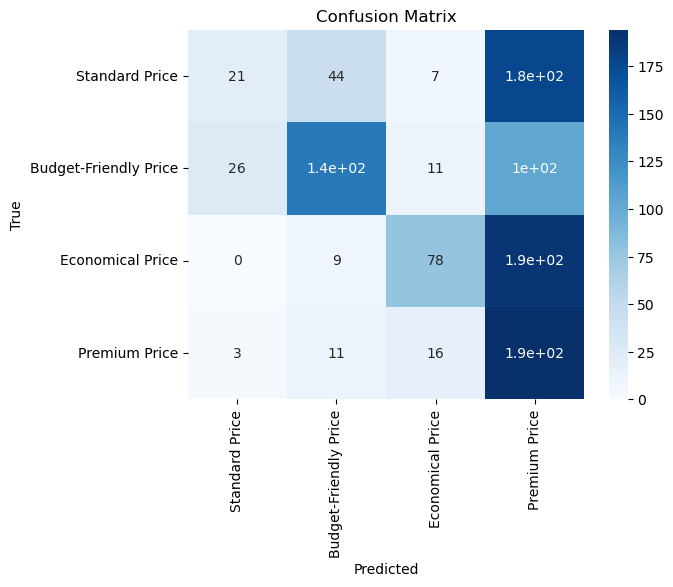

In [48]:
# Print the confusion matrix
sns.heatmap(cm_multinomial_nb, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


print("Accuracy of Multinomial Naive Bayes: " + str(accuracy_multinomial_nb))

## Results:

The goal is to classify properties into four different categories based on certain features. The four categories are 'Standard Price,' 'Budget-Friendly Price,' 'Economical Price,' and 'Premium Price.' These categories likely represent different price ranges or property types, and the classification model aims to assign each property to one of these categories.

The model has been trained on a dataset that includes information about the properties, such as their size, number of bedrooms, number of bathrooms, property type, heating type, cooling type, and other relevant features. These features are used to make predictions about the price category of each property.


## Multinomial Naive Bayes Results:

The Multinomial Naive Bayes model's performance is evaluated using a confusion matrix, which shows how well it predicts the actual price category of properties. The matrix provides details on the number of correct predictions (diagonal elements) and misclassifications for each category.

From the confusion matrix, we can infer the below information:

The model correctly predicted that 140 properties fall into the 'Budget-Friendly Price' category.
However, it misclassified 44 properties that belong to the 'Standard Price' category as 'Budget-Friendly Price.'
It also correctly predicted 78 properties in the 'Economical Price' category but misclassified 9 properties as 'Premium Price' and 189 properties as 'Standard Price.'
Additionally, 194 properties in the 'Premium Price' category were correctly predicted, but 11 were misclassified as 'Budget-Friendly Price' and 16 as 'Standard Price.'

The accuracy of the Multinomial Naive Bayes model in this context is 0.4204, which means that it correctly predicted approximately 42.04% of the property price categories. An accuracy score of 1.0 would indicate a perfect classification model, while a score of 0.0 would indicate random or highly inaccurate predictions.

This classification model could be valuable for various applications, such as real estate or property valuation, where automatic categorization of properties can help users or businesses quickly identify properties that match their criteria or preferences. Further analysis and fine-tuning of the model may be necessary to improve its classification accuracy, especially for specific categories of interest.

# Bernoulli Naive Bayes

In [49]:
bernoulli_nb = BernoulliNB()

In [50]:
bernoulli_nb.fit(X_train, y_train)

BernoulliNB()

In [51]:
y_pred_bernoulli_nb = bernoulli_nb.predict(X_test)

In [52]:
accuracy_bernoulli_nb = accuracy_score(y_test, y_pred_bernoulli_nb)
cm_bernoulli_nb = confusion_matrix(y_test, y_pred_bernoulli_nb)
print(cm_bernoulli_nb)

[[ 16  98 101  34]
 [ 14 203  48  16]
 [  4  12 226  34]
 [  5  51 140  28]]


Accuracy of Bernoulli Naive Bayes: 0.45922330097087377


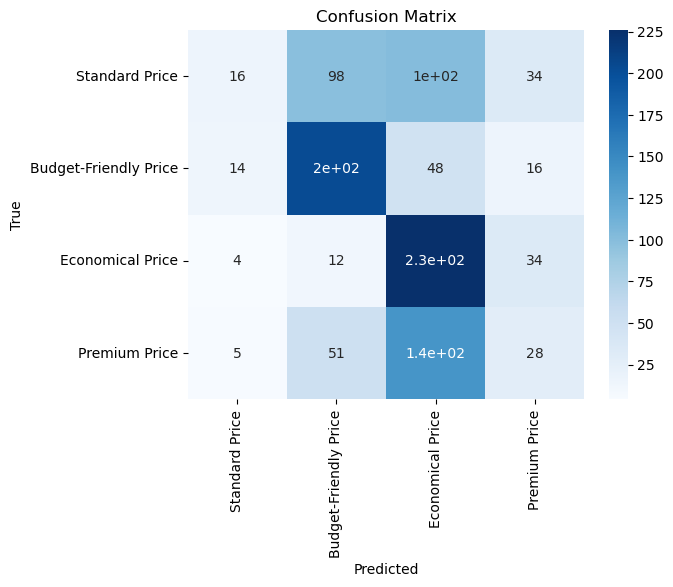

In [53]:
# Print the confusion matrix
sns.heatmap(cm_bernoulli_nb, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


print("Accuracy of Bernoulli Naive Bayes: " + str(accuracy_bernoulli_nb))

In [54]:
print(class_names)

['Standard Price', 'Budget-Friendly Price', 'Economical Price', 'Premium Price']
Categories (4, object): ['Economical Price' < 'Budget-Friendly Price' < 'Standard Price' < 'Premium Price']


## Bernoulli Naive Bayes Results:

The Bernoulli Naive Bayes model, like the Multinomial Naive Bayes, has been trained on a dataset containing various features related to properties. These features include information such as property size, number of bedrooms, number of bathrooms, property type, heating type, cooling type, and other relevant attributes. The model leverages this information to predict the price category of each property.

The performance of the Bernoulli Naive Bayes model is assessed using a confusion matrix, which outlines the model's predictions compared to the actual property price categories. The matrix details both correct predictions (diagonal elements) and misclassifications for each category.

From the confusion matrix, we can infer the below information:

The model correctly predicted that 203 properties fall into the 'Budget-Friendly Price' category.
However, it misclassified 98 properties from the 'Standard Price' category as 'Budget-Friendly Price,' and 101 properties as 'Economical Price.'
It also correctly predicted 226 properties in the 'Economical Price' category but misclassified 12 properties as 'Budget-Friendly Price' and 34 properties as 'Premium Price.'
Furthermore, 28 properties in the 'Premium Price' category were correctly predicted, but 140 were misclassified as 'Budget-Friendly Price,' and 51 as 'Economical Price.'
The accuracy of the Bernoulli Naive Bayes model in this context is approximately 0.4592, which means it correctly predicted about 45.92% of the property price categories. 

# Gaussian Naive Bayes

In [54]:
gaussian_NB = GaussianNB()

In [55]:
gaussian_NB.fit(X_train, y_train)

GaussianNB()

In [56]:
y_pred_gaussian_nb = gaussian_NB.predict(X_test)

In [57]:
accuracy_gaussian_nb = accuracy_score(y_test, y_pred_gaussian_nb)
cm_gaussian_nb = confusion_matrix(y_test, y_pred_gaussian_nb)
print(cm_gaussian_nb)

[[ 30  27   2 190]
 [ 65  86   1 129]
 [ 31   8  43 194]
 [  6   7   6 205]]


Accuracy of Gaussian Naive Bayes: 0.3533980582524272


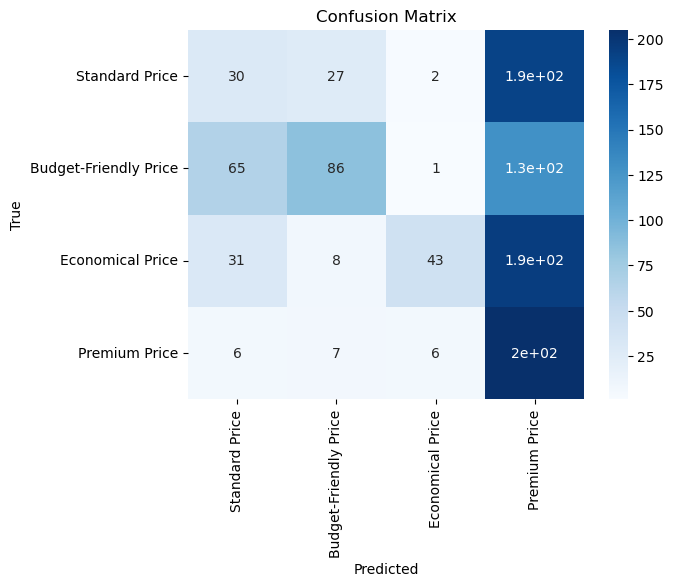

In [59]:
sns.heatmap(cm_gaussian_nb, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


print("Accuracy of Gaussian Naive Bayes: " + str(accuracy_gaussian_nb))

## Gaussian Naive Bayes Results:

In this analysis, a Gaussian Naive Bayes model was applied to a dataset consisting of various property-related features for the purpose of categorizing properties into four distinct price categories: 'Standard Price,' 'Budget-Friendly Price,' 'Economical Price,' and 'Premium Price.' These categories represent different price ranges or types of properties.


### Confusion Matrix:

The confusion matrix provides a breakdown of the model's predictions. Each row in the matrix corresponds to the actual (true) price category of properties, while each column represents the predicted price category.

Looking at the diagonal of the matrix, we can see the number of correct predictions for each category:
The model correctly predicted 30 properties in the 'Standard Price' category.
It also correctly predicted 86 properties in the 'Budget-Friendly Price' category.
For the 'Economical Price' category, the model made 43 correct predictions.
Finally, it accurately predicted 205 properties in the 'Premium Price' category.
Misclassifications are observed outside the diagonal:

For example, 65 properties originally in the 'Standard Price' category were incorrectly classified as 'Budget-Friendly Price,' and 129 properties from the 'Budget-Friendly Price' category were misclassified.
In addition, 31 properties from the 'Economical Price' category were misclassified as 'Standard Price,' and 194 properties were wrongly predicted as 'Premium Price.'

### Accuracy:
The accuracy of the Gaussian Naive Bayes model is approximately 0.3534. This value indicates that the model made accurate predictions for about 35.34% of the property price categories. An accuracy score of 1.0 would mean a perfect classification model, while a score of 0.0 would suggest random or highly inaccurate predictions.

### Interpretation:
Based on these results, the Gaussian Naive Bayes model's performance is relatively modest in this context. It seems to struggle with classifying properties into the specified price categories. The relatively low accuracy score suggests that there is room for improvement in the model's predictive power.

The choice of Gaussian NB might be less suitable for this dataset. Gaussian Naive Bayes assumes that features are normally distributed, and if the properties data does not meet this assumption, it can lead to less effective classification. To potentially improve the model's performance, other classification algorithms or feature engineering techniques could be explored. Additionally, it might be valuable to investigate the distribution of features and their relevance to the task to better understand the model's limitations.